In [21]:
%run hapclust_utils.ipynb

In [2]:
callset = h5py.File('../data/ag1000g.phase1.AR3.1.haplotypes.specific_regions.2L_2358158_2431617.h5',
                    mode='r')
region_vgsc = SeqFeature('2L', 2358158, 2431617)
genotypes = allel.GenotypeArray(callset['2L/calldata/genotype'])
haplotypes = genotypes.to_haplotypes()
pos = allel.SortedIndex(callset['2L/variants/POS'])
loc = pos.locate_range(region_vgsc.start, region_vgsc.end)
h_vgsc = haplotypes[loc]
pos_995S = 2422651
pos_995F = 2422652
loc_995S = haplotypes[pos.locate_key(pos_995S)] == 1
loc_995F = haplotypes[pos.locate_key(pos_995F)] == 1
h_vgsc_995F = h_vgsc.compress(loc_995F, axis=1)
h_vgsc_995S = h_vgsc.compress(loc_995S, axis=1)
sample_ids = callset['2L']['samples'][:]
hap_ids = np.array(list(itertools.chain(*[[s + b'a', s + b'b'] for s in sample_ids])))
hap_ids_995F = hap_ids[loc_995F]
hap_ids_995S = hap_ids[loc_995S]
tbl_haplotypes = etl.fromtsv('../data/ag1000g.phase1.AR3.1.haplotypes.meta.txt')
hap_pops = np.array(tbl_haplotypes.values('population'))
hap_pops_995S = hap_pops[loc_995S]
hap_pops_995F = hap_pops[loc_995F]
# need to use named colors for graphviz
pop_colors = {
    'AOM': 'brown',
    'BFM': 'firebrick1',
    'GWA': 'goldenrod1',
    'GNS': 'cadetblue1',
    'BFS': 'deepskyblue',
    'CMS': 'dodgerblue3',
    'UGS': 'palegreen',
    'GAS': 'olivedrab',
    'KES': 'grey47',
    'colony': 'black'
}
hap_colors = np.array([pop_colors[p] for p in hap_pops])
hap_colors_995S = np.array([pop_colors[p] for p in hap_pops_995S])
hap_colors_995F = np.array([pop_colors[p] for p in hap_pops_995F])

tbl_variant_labels = (
    etl
    .frompickle('../data/tbl_variants_phase1.pkl')
    .eq('num_alleles', 2)
    .cut('POS', 'REF', 'ALT', 'AGAP004707-RA')
    .convert('AGAP004707-RA', lambda v: v[1] if v[0] == 'NON_SYNONYMOUS_CODING' else '')
    .addfield('label', lambda row: row['AGAP004707-RA'] if row['AGAP004707-RA'] else '%s:%s>%s' % (row.POS - region_vgsc.start, row.REF, row.ALT))
)
tbl_variant_labels

0|POS,1|REF,2|ALT,3|AGAP004707-RA,4|label
2358254,G,A,D33N,D33N
2358316,T,G,,158:T>G
2358328,T,C,,170:T>C
2358353,C,T,,195:C>T
2358405,T,A,,247:T>A


In [3]:
pos2label = tbl_variant_labels.lookupone('POS', 'label')
pos2label[pos_995F]

'L995F'

In [4]:
pos2label_coding = tbl_variant_labels.lookupone('POS', 'AGAP004707-RA')
pos2label_coding[pos_995F]

'L995F'

In [5]:
variant_labels = np.array([pos2label.get(p, '') for p in pos], dtype=object)
variant_labels_vgsc = variant_labels[loc]
variant_labels_vgsc

array(['D33N', '158:T>G', '170:T>C', ..., '73360:C>A', '73369:G>C',
       '73384:T>C'], dtype=object)

In [6]:
variant_labels_coding = np.array([pos2label_coding.get(p, '') for p in pos], dtype=object)
variant_labels_coding_vgsc = variant_labels_coding[loc]
variant_labels_coding_vgsc

array(['D33N', '', '', ..., '', '', ''], dtype=object)

In [7]:
%%cython


cimport numpy as cnp
import numpy as np


def count_gametes(cnp.int8_t[:, :] h):
    """Count the number of each gametic type observed for each pair of variants. 
    Observation of all four gametic types for any pair of variants is evidence for 
    recombination."""
    
    cdef:
        Py_ssize_t n, m, i, j, k
        cnp.uint8_t[:, :] d
        cnp.uint32_t[:, :, :, :] count
    
    n = h.shape[0]
    m = h.shape[1]
    count = np.zeros((n, n, 2, 2), dtype='u4')
    for i in range(n):
        for j in range(i+1, n):
            for k in range(m):
                count[i, j, h[i, k], h[j, k]] += 1
                
    return np.asarray(count)

In [9]:
def locate_recombination(h):
    """Locate recombinant haplotypes via the four gamete test."""
    count = count_gametes(np.asarray(h, dtype='i1'))
    d = np.all(count > 0, axis=(2, 3))
    rec_idx = set()
    for i, j in zip(*np.nonzero(d)):
        least_frequent_gamete = np.unravel_index(np.argmin(count[i, j]), (2, 2))
        recombinant_haps_idx = np.nonzero(np.all(h[[i, j], :] == np.array(least_frequent_gamete)[:, np.newaxis], axis=0))[0]
#         print(i, j, count[i, j].flatten(), least_frequent_gamete, recombinant_haps_idx)
        rec_idx |= set(recombinant_haps_idx)
    return sorted(rec_idx)

## L995S

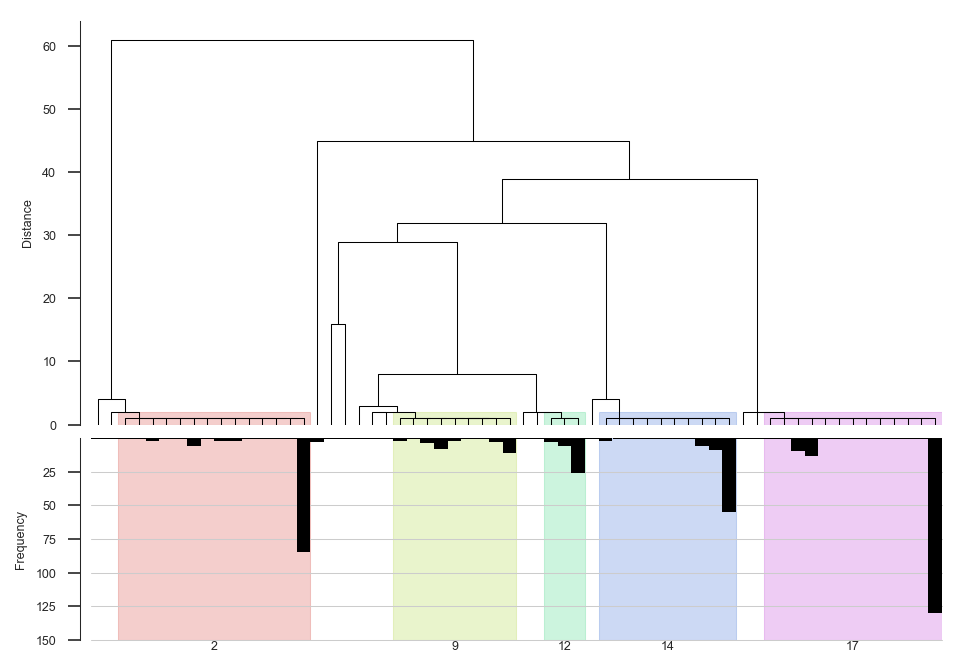

In [10]:
cut_height = 2
fig, ax_dend, ax_freq, cluster_spans_995S, leaf_obs_995S = fig_haplotypes_clustered(h_vgsc_995S, cut_height=cut_height, dpi=150, 
                                                                          highlight_clusters=5, label_clusters=5)


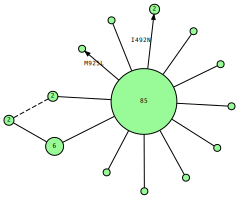

In [23]:
cluster_idx = 2
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995S[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995S.take(cluster_hap_indices)
graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', variant_labels=variant_labels_coding_vgsc, fontsize=6, mode='major', edge_weight=10, show_node_labels='count')

found 2 recombinant haplotypes: [13, 60]


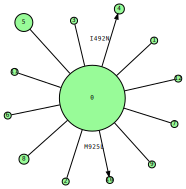

In [12]:
idx_rec = locate_recombination(cluster_haps)
print('found', len(idx_rec), 'recombinant haplotypes:', idx_rec)
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
graph_haplotype_network(cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', variant_labels=variant_labels_coding_vgsc, fontsize=6)

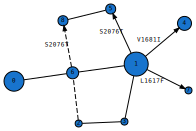

In [13]:
cluster_idx = 9
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995S[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995S.take(cluster_hap_indices)
graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', variant_labels=variant_labels_coding_vgsc, fontsize=6, mode='major', edge_weight=10)

found 3 recombinant haplotypes: [9, 14, 19]


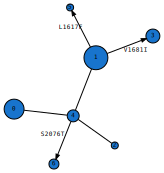

In [14]:
idx_rec = locate_recombination(cluster_haps)
print('found', len(idx_rec), 'recombinant haplotypes:', idx_rec)
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
graph_haplotype_network(cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', variant_labels=variant_labels_coding_vgsc, fontsize=6)

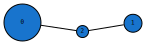

In [15]:
cluster_idx = 12
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995S[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995S.take(cluster_hap_indices)
graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', variant_labels=variant_labels_coding_vgsc, fontsize=6, mode='major', edge_weight=10)

found 0 recombinant haplotypes: []


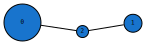

In [16]:
idx_rec = locate_recombination(cluster_haps)
print('found', len(idx_rec), 'recombinant haplotypes:', idx_rec)
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
graph_haplotype_network(cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', variant_labels=variant_labels_coding_vgsc, fontsize=6)

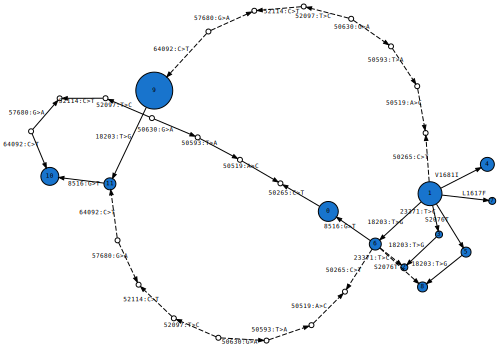

In [17]:
cluster_idx = 9, 12
cluster_hap_indices = list()
for i in cluster_idx:
    _, _, hix = cluster_spans_995S[i]
    cluster_hap_indices.extend(hix)
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995S.take(cluster_hap_indices)
graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', max_dist=10,
                        variant_labels=variant_labels_vgsc, fontsize=6, mode='major', edge_weight=10)

found 12 recombinant haplotypes: [9, 14, 19, 34, 37, 39, 41, 51, 53, 55, 56, 60]


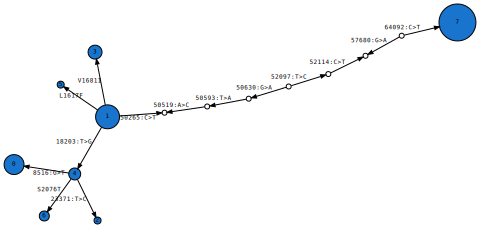

In [18]:
idx_rec = locate_recombination(cluster_haps)
print('found', len(idx_rec), 'recombinant haplotypes:', idx_rec)
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
graph_haplotype_network(cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', max_dist=10,
                        variant_labels=variant_labels_vgsc, fontsize=6)

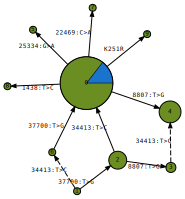

In [181]:
cluster_idx = 14
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995S[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995S.take(cluster_hap_indices)
graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', variant_labels=variant_labels_vgsc, fontsize=6, mode='major', edge_weight=10)

224 895 [ 7 60  2  9] (1, 0) [20 24]
895 1031 [ 1  8  1 68] (0, 0) [16]


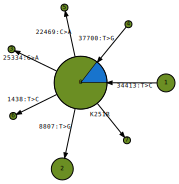

In [182]:
idx_rec = locate_recombination(cluster_haps)
print('found', len(idx_rec), 'recombinant haplotypes')
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
graph_haplotype_network(cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', variant_labels=variant_labels_vgsc, fontsize=6)

## L995F

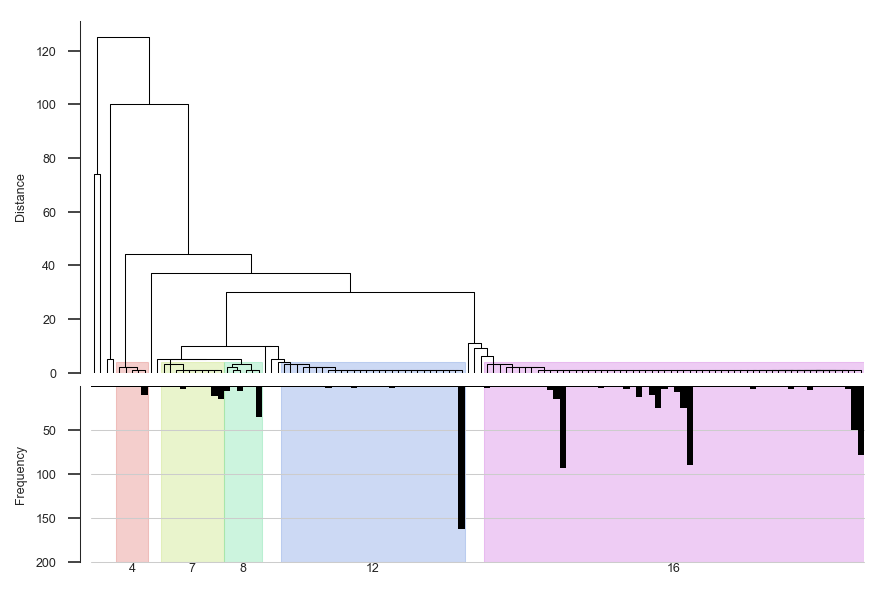

In [185]:
cut_height = 4
fig, ax_dend, ax_freq, cluster_spans_995F, leaf_obs_995F = fig_haplotypes_clustered(h_vgsc_995F, cut_height=cut_height, dpi=150, 
                                                                          highlight_clusters=5, label_clusters=5)


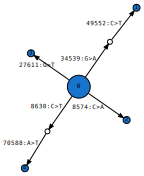

In [186]:
cluster_idx = 4
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995F.take(cluster_hap_indices)
graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', variant_labels=variant_labels_vgsc, fontsize=6, mode='major', edge_weight=10)

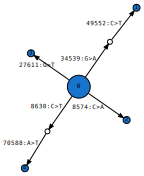

In [187]:
idx_rec = locate_recombination(cluster_haps)
print('found', len(idx_rec), 'recombinant haplotypes')
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
graph_haplotype_network(cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', variant_labels=variant_labels_vgsc, fontsize=6)

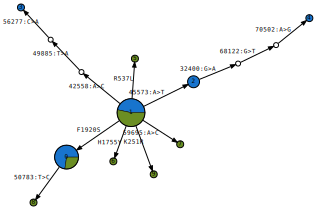

In [188]:
cluster_idx = 7
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995F.take(cluster_hap_indices)
graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', variant_labels=variant_labels_vgsc, fontsize=6, mode='major', edge_weight=10)

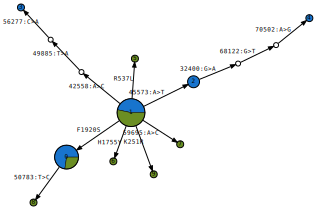

In [189]:
idx_rec = locate_recombination(cluster_haps)
print('found', len(idx_rec), 'recombinant haplotypes')
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
graph_haplotype_network(cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', variant_labels=variant_labels_vgsc, fontsize=6)

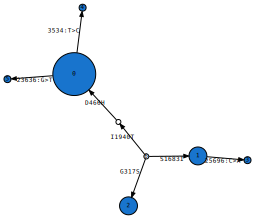

In [190]:
cluster_idx = 8
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995F.take(cluster_hap_indices)
graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', variant_labels=variant_labels_vgsc, fontsize=6, mode='major', edge_weight=10)

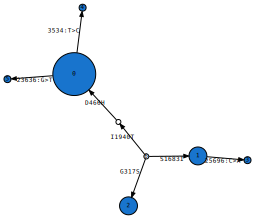

In [191]:
idx_rec = locate_recombination(cluster_haps)
print('found', len(idx_rec), 'recombinant haplotypes')
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
graph_haplotype_network(cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', variant_labels=variant_labels_vgsc, fontsize=6)

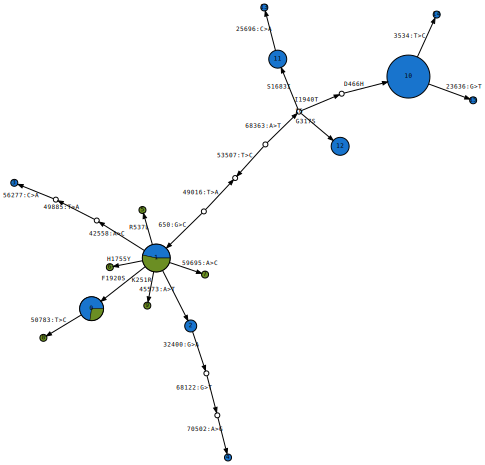

In [201]:
cluster_idx = 7, 8
cluster_hap_indices = list()
for i in cluster_idx:
    _, _, hix = cluster_spans_995F[i]
    cluster_hap_indices.extend(hix)
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995F.take(cluster_hap_indices)
graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', variant_labels=variant_labels_vgsc, fontsize=6, mode='major', edge_weight=10)

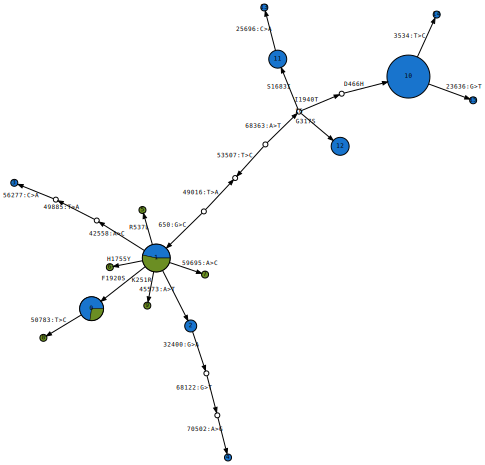

In [202]:
idx_rec = locate_recombination(cluster_haps)
print('found', len(idx_rec), 'recombinant haplotypes')
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
graph_haplotype_network(cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', variant_labels=variant_labels_vgsc, fontsize=6)

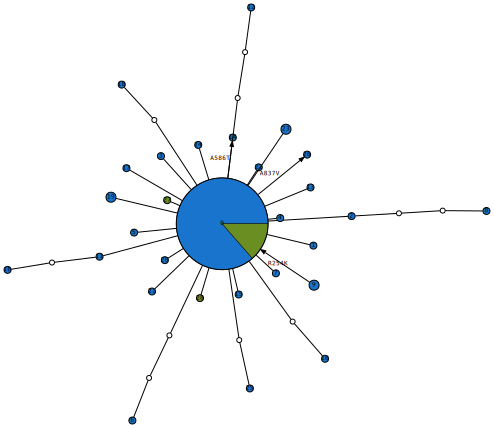

In [203]:
cluster_idx = 12
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995F.take(cluster_hap_indices)
graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', variant_labels=variant_labels_coding_vgsc, fontsize=6, mode='major', edge_weight=10)

6 1698 [  4   1 442  28] (0, 1) [172]
6 1699 [  4   1 391  79] (0, 1) [39]
147 1674 [  1   1 364 109] (0, 0) [243]
147 1698 [  1   1 445  28] (0, 0) [291]
224 1674 [358 109   7   1] (1, 1) [282]
1379 1674 [361 109   4   1] (1, 1) [474]
1379 1681 [467   3   2   3] (1, 0) [473 474]
1379 1697 [418  52   4   1] (1, 1) [473]
1433 1695 [431  12  31   1] (1, 1) [87]
1698 1704 [431  15  28   1] (1, 1) [242]
found 9 recombinant haplotypes


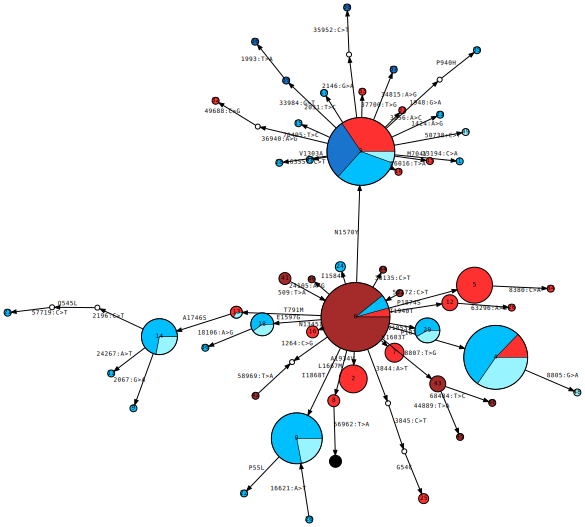

In [236]:
idx_rec = locate_recombination(cluster_haps)
print('found', len(idx_rec), 'recombinant haplotypes')
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
graph_haplotype_network(cluster_haps_norec, hap_colors=cluster_hap_colors_norec, network_method='mjn', variant_labels=variant_labels_vgsc, fontsize=6)

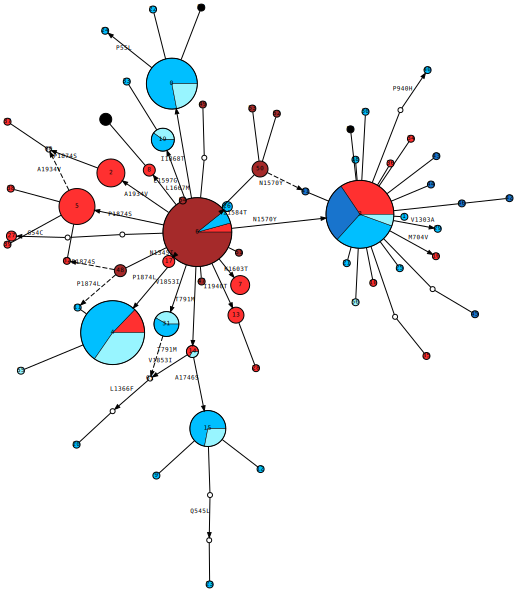

In [205]:
cluster_idx = 16
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_colors = hap_colors_995F.take(cluster_hap_indices)
graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, network_method='mjn', variant_labels=variant_labels_coding_vgsc, 
                        fontsize=6, mode='major', edge_weight=10)

6 1698 [  4   1 442  28] (0, 1) [172]
6 1699 [  4   1 391  79] (0, 1) [39]
147 1674 [  1   1 364 109] (0, 0) [243]
147 1698 [  1   1 445  28] (0, 0) [291]
224 1674 [358 109   7   1] (1, 1) [282]
1379 1674 [361 109   4   1] (1, 1) [474]
1379 1681 [467   3   2   3] (1, 0) [473 474]
1379 1697 [418  52   4   1] (1, 1) [473]
1433 1695 [431  12  31   1] (1, 1) [87]
1698 1704 [431  15  28   1] (1, 1) [242]
found 9 recombinant haplotypes


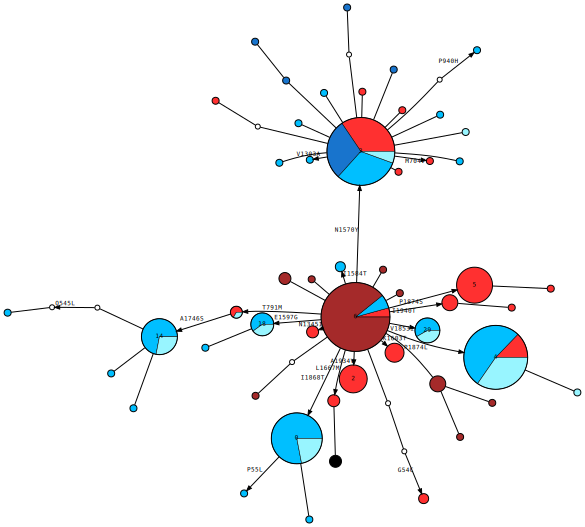

In [235]:
idx_rec = locate_recombination(cluster_haps)
print('found', len(idx_rec), 'recombinant haplotypes')
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec]
cluster_haps_norec = cluster_haps.take(idx_norec, axis=1)
cluster_hap_colors_norec = cluster_hap_colors.take(idx_norec)
graph_haplotype_network(cluster_haps_norec, hap_colors=cluster_hap_colors_norec, variant_labels=variant_labels_coding_vgsc, overlap=True, splines=True,
                        network_method='mjn', mode='major', fontsize=6, show_node_labels=10)

## Sandbox

In [84]:
count = count_gametes(np.asarray(cluster_haps))
count[0, 1]

array([[106,   0],
       [  0,   0]], dtype=uint32)

In [85]:
count[0, 2]

array([[106,   0],
       [  0,   0]], dtype=uint32)

In [64]:
d = np.all(count > 0, axis=(2, 3))

In [65]:
np.any(d)

True

In [66]:
np.count_nonzero(d)

1

In [79]:
np.unravel_index?

In [67]:
np.nonzero(d)

(array([221]), array([1473]))

In [77]:
np.argmin?

In [81]:
np.argmin([[2, 2], [6, 96]], )

0

In [82]:
np.unravel_index(0, (2, 2))

(0, 0)

In [70]:
for i, j in zip(*np.nonzero(d)):
    print(i, j, count[i, j].flatten())

221 1473 [ 2  2  6 96]


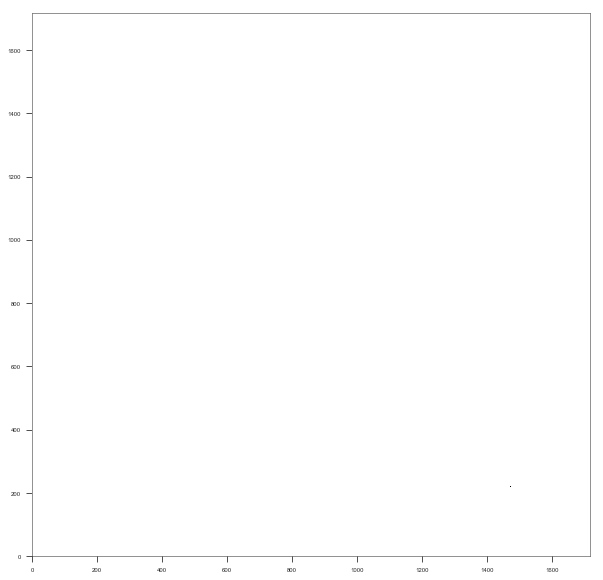

In [47]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.pcolormesh(d, vmin=0, vmax=1)